## Load State and Action data

In [22]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [23]:
# We load the logged state and scheduling actions from the default scheduler
states = pd.read_csv("../data/states.csv")
actions = pd.read_csv("../data/actions.csv")

# We convert some units
# Some unity conversion

states["node_cpu_total"] = states["node_cpu_total_milli"] / 1000.0
states["pod_cpu_request"] = states["pod_cpu_request_milli"] / 1000.0
states["pod_ram_request_mib"] = states["pod_ram_request_mib"] / (1024.0 * 1024.0)

# Datetime conversion
states["timestamp"] = pd.to_datetime(states["timestamp"])
actions["timestamp"] = pd.to_datetime(actions["timestamp"])

In [3]:
actions.head()

,timestamp,pod_name,chosen_node_name
0,2025-05-31 14:54:07.555752709+00:00,workload-6924,cloud-7
1,2025-05-31 14:54:07.671938305+00:00,workload-8868,cloud-6
2,2025-05-31 14:54:07.773946227+00:00,workload-7539,cloud-5
3,2025-05-31 14:54:07.900168788+00:00,workload-4565,cloud-3
4,2025-05-31 14:54:08.025001287+00:00,workload-594,cloud-6


In [4]:
states.head()

,timestamp,pod_name,pod_cpu_request_milli,pod_ram_request_mib,candidate_node_name,node_cpu_total_milli,node_ram_total_mib,node_cpu_model_energy_val,node_type,energy_before,energy_after,node_cpu_total,pod_cpu_request
0,2025-05-31 14:54:07.535977633+00:00,workload-6924,6000,3072.0,cloud-1,8000,16384,169.5159,cloud,225.5013,582.9039,8.0,6.0
1,2025-05-31 14:54:07.536603485+00:00,workload-6924,6000,3072.0,cloud-2,10000,24576,179.1791,cloud,223.5013,546.4454,10.0,6.0
2,2025-05-31 14:54:07.538592719+00:00,workload-6924,6000,3072.0,cloud-6,24000,61440,179.1791,cloud,214.5013,389.1925,24.0,6.0
3,2025-05-31 14:54:07.539086571+00:00,workload-6924,6000,3072.0,cloud-8,8000,40960,166.3510,cloud,200.5013,590.9039,8.0,6.0
4,2025-05-31 14:54:07.540654240+00:00,workload-6924,6000,3072.0,cloud-4,6000,49152,166.3510,cloud,226.5013,729.9514,6.0,6.0


In [26]:
# Assuming these constants are defined elsewhere or passed in
UNSCHEDULABLE_PENALTY = -1000.0 # Example penalty

def encode_node_type(node_type_str: str) -> float:
    if node_type_str == 'edge':
        return 1.0
    elif node_type_str == 'cloud':
        return 2.0
    else: # unknown or other
        return 0.0
    
def get_bonus_coeff(node_type_str: str) -> float:
    if node_type_str == 'edge':
        return 0.7 # Example bonus coefficient for edge nodes
    else:
        return 1.0

def build_transitions(state_df: pd.DataFrame, action_df: pd.DataFrame, unschedulable_penalty=UNSCHEDULABLE_PENALTY):
    """
    Build transitions using ALL state evaluations, not just chosen actions.
    Each (pod, candidate_node) pair becomes a potential state-action with appropriate labeling.
    """
    transitions = []
    
    # Create a mapping of pod_name -> chosen_node_name for quick lookup
    action_map = dict(zip(action_df['pod_name'], action_df['chosen_node_name']))
    
    # Group state_df by pod_name to process all candidate nodes for each pod
    for pod_name, pod_group in state_df.groupby('pod_name'):
        
        # Check if this pod was successfully scheduled
        if pod_name in action_map:
            chosen_node = action_map[pod_name]
            
            # Process each candidate node evaluation for this pod
            for _, state_row in pod_group.iterrows():
                candidate_node = state_row['candidate_node_name']
                
                # Build state representation for this (pod, candidate_node) pair
                s_t = np.array([
                    state_row['pod_cpu_request_milli'],
                    state_row['pod_ram_request_mib'], 
                    state_row['node_cpu_total_milli'],
                    state_row['node_ram_total_mib'],
                    state_row['node_cpu_model_energy_val'],
                    encode_node_type(state_row['node_type']),
                    state_row['energy_before']
                ], dtype=np.float32)
                
                # Determine if this candidate node was the chosen action
                if candidate_node == chosen_node:
                    # This was the CHOSEN action - use actual energy_after as basis for reward
                    r_t = -float(state_row['energy_after']) * get_bonus_coeff(state_row['node_type'])
                    
                    # Next state represents the node after placement
                    s_next = np.array([
                        0.0,  # Placeholder for next pod's CPU
                        0.0,  # Placeholder for next pod's RAM  
                        state_row['node_cpu_total_milli'],
                        state_row['node_ram_total_mib'],
                        state_row['node_cpu_model_energy_val'],
                        encode_node_type(state_row['node_type']),
                        state_row['energy_after']
                    ], dtype=np.float32)
                    
                    done = False
                    action_label = "CHOSEN"
                    
                else:
                    # This was a NON-CHOSEN action - use energy_after as counterfactual reward
                    # This represents "what would have happened if we chose this node instead"
                    r_t = -float(state_row['energy_after']) * get_bonus_coeff(state_row['node_type'])
                    
                    # Next state represents what the node would look like after placement
                    s_next = np.array([
                        0.0,  # Placeholder for next pod's CPU
                        0.0,  # Placeholder for next pod's RAM
                        state_row['node_cpu_total_milli'], 
                        state_row['node_ram_total_mib'],
                        state_row['node_cpu_model_energy_val'],
                        encode_node_type(state_row['node_type']),
                        state_row['energy_after']  # Counterfactual energy after placement
                    ], dtype=np.float32)
                    
                    done = False
                    action_label = "NOT_CHOSEN"
                
                # Store transition with additional metadata
                transitions.append((s_t, r_t, s_next, done, pod_name, candidate_node, action_label))
        
        else:
            # Pod was unschedulable - all its candidate evaluations are negative examples
            for _, state_row in pod_group.iterrows():
                candidate_node = state_row['candidate_node_name']
                
                s_t_unsched = np.array([
                    state_row['pod_cpu_request_milli'],
                    state_row['pod_ram_request_mib'],
                    state_row['node_cpu_total_milli'], 
                    state_row['node_ram_total_mib'],
                    state_row['node_cpu_model_energy_val'],
                    encode_node_type(state_row['node_type']),
                    state_row['energy_before']
                ], dtype=np.float32)
                
                r_t_unsched = unschedulable_penalty
                s_next_unsched = np.zeros_like(s_t_unsched, dtype=np.float32)  # Terminal state
                done_unsched = True
                
                transitions.append((s_t_unsched, r_t_unsched, s_next_unsched, done_unsched, 
                                 pod_name, candidate_node, "UNSCHEDULABLE"))
    
    print(f"Generated {len(transitions)} transitions from {len(state_df)} state evaluations")
    print(f"Breakdown:")
    chosen_count = sum(1 for t in transitions if t[6] == "CHOSEN")
    not_chosen_count = sum(1 for t in transitions if t[6] == "NOT_CHOSEN") 
    unschedulable_count = sum(1 for t in transitions if t[6] == "UNSCHEDULABLE")
    print(f"  - CHOSEN actions: {chosen_count}")
    print(f"  - NOT_CHOSEN actions: {not_chosen_count}")
    print(f"  - UNSCHEDULABLE actions: {unschedulable_count}")
    
    return transitions


def create_weighted_experience_replay_buffer(transitions, chosen_weight=1.0, not_chosen_weight=0.3, unschedulable_weight=1.0):
    """
    Create a weighted sampling strategy for the experience replay buffer.
    This helps balance the training since NOT_CHOSEN actions are much more numerous.
    """
    weighted_transitions = []
    
    for transition in transitions:
        action_label = transition[6]  # 7th element is the action label
        
        if action_label == "CHOSEN":
            weight = chosen_weight
        elif action_label == "NOT_CHOSEN": 
            weight = not_chosen_weight
        else:  # UNSCHEDULABLE
            weight = unschedulable_weight
            
        weighted_transitions.append((transition, weight))
    
    return weighted_transitions

In [27]:
transitions = build_transitions(states, actions)


print(f"Total transitions built: {len(transitions)}")

Generated 552 transitions from 552 state evaluations
Breakdown:
  - CHOSEN actions: 49
  - NOT_CHOSEN actions: 503
  - UNSCHEDULABLE actions: 0
Total transitions built: 552


## Build and train DQN

DQN are essentially a feed forward network that takes in states as input and return the Q-values as an output that we will use to make an action: decide on which node to place the current pod.

We will build the simple DQN network with PyTorch

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
from collections import deque
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

In [29]:


class DQNScheduler(nn.Module):
    """
    Deep Q-Network for Kubernetes Pod Scheduling
    State: [pod_cpu, pod_ram, node_cpu, node_ram, node_energy_model, node_type, energy_before]
    Action: Node selection (implicit - each forward pass evaluates one node)
    """
    def __init__(self, state_dim=7, hidden_dims=[256, 128, 64], dropout=0.2):
        super(DQNScheduler, self).__init__()
        
        # Build network layers
        layers = []
        prev_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        # Output layer - Q-value for this state-action pair
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, state):
        """Return Q-value for the given state"""
        return self.network(state)

class ReplayBuffer:
    """Experience Replay Buffer with weighted sampling support"""
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
        self.weights = deque(maxlen=capacity)
        
    def push(self, transition, weight=1.0):
        self.buffer.append(transition)
        self.weights.append(weight)
        
    def sample(self, batch_size, use_weights=True):
        if use_weights and len(self.weights) > 0:
            # Weighted sampling
            weights_array = np.array(self.weights)
            weights_array = weights_array / weights_array.sum()  # Normalize
            indices = np.random.choice(len(self.buffer), batch_size, p=weights_array, replace=True)
            batch = [self.buffer[i] for i in indices]
        else:
            # Uniform sampling
            batch = random.sample(self.buffer, batch_size)
        
        return batch
    
    def __len__(self):
        return len(self.buffer)

class DQNTrainer:
    """DQN Training Manager for Kubernetes Scheduler"""
    
    def __init__(self, state_dim=7, lr=1e-3, gamma=0.99, epsilon_start=1.0, 
                 epsilon_end=0.01, epsilon_decay=0.995, buffer_size=10000):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Networks
        self.q_network = DQNScheduler(state_dim).to(self.device)
        self.target_network = DQNScheduler(state_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Training parameters
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Experience replay
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        # Training history
        self.losses = []
        self.rewards = []
        
    def add_transitions(self, transitions, weights=None):
        """Add transitions to replay buffer"""
        if weights is None:
            weights = [1.0] * len(transitions)
            
        for transition, weight in zip(transitions, weights):
            # Unpack transition: (s_t, r_t, s_next, done, pod_name, node_name, action_label)
            state, reward, next_state, done, pod_name, node_name, action_label = transition
            
            # Store simplified transition for DQN
            self.replay_buffer.push((state, reward, next_state, done), weight)
    
    def train_step(self, batch_size=32):
        """Perform one training step"""
        if len(self.replay_buffer) < batch_size:
            return None
            
        batch = self.replay_buffer.sample(batch_size)
        states = torch.FloatTensor([t[0] for t in batch]).to(self.device)
        rewards = torch.FloatTensor([t[1] for t in batch]).to(self.device)
        next_states = torch.FloatTensor([t[2] for t in batch]).to(self.device)
        dones = torch.BoolTensor([t[3] for t in batch]).to(self.device)
        
        # Current Q-values
        current_q_values = self.q_network(states).squeeze()
        
        # Next Q-values from target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states).squeeze()
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        self.losses.append(loss.item())
        return loss.item()
    
    def update_target_network(self):
        """Update target network with current network weights"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
    
    def train(self, num_episodes=1000, batch_size=32, update_target_freq=100, 
              print_freq=100, use_weighted_sampling=True):
        """Train the DQN"""
        print(f"Starting training for {num_episodes} episodes...")
        print(f"Replay buffer size: {len(self.replay_buffer)}")
        
        for episode in range(num_episodes):
            # Train step
            loss = self.train_step(batch_size)
            
            # Update target network
            if episode % update_target_freq == 0:
                self.update_target_network()
            
            # Decay epsilon
            self.decay_epsilon()
            
            # Print progress
            if episode % print_freq == 0 and loss is not None:
                avg_loss = np.mean(self.losses[-print_freq:]) if len(self.losses) >= print_freq else np.mean(self.losses)
                print(f"Episode {episode}, Avg Loss: {avg_loss:.4f}, Epsilon: {self.epsilon:.3f}")
        
        print("Training completed!")
    
    def predict_node_ranking(self, pod_state, candidate_nodes_states):
        """
        Predict ranking of candidate nodes for a given pod
        Args:
            pod_state: [pod_cpu, pod_ram] 
            candidate_nodes_states: List of [node_cpu, node_ram, node_energy_model, node_type, energy_before]
        Returns:
            List of (node_index, q_value) sorted by Q-value (descending)
        """
        self.q_network.eval()
        
        q_values = []
        with torch.no_grad():
            for i, node_state in enumerate(candidate_nodes_states):
                # Combine pod and node features
                full_state = np.concatenate([pod_state, node_state])
                state_tensor = torch.FloatTensor(full_state).unsqueeze(0).to(self.device)
                
                q_value = self.q_network(state_tensor).item()
                q_values.append((i, q_value))
        
        # Sort by Q-value (higher is better)
        q_values.sort(key=lambda x: x[1], reverse=True)
        return q_values
    
    def save_model(self, filepath):
        """Save the trained model"""
        torch.save({
            'q_network_state': self.q_network.state_dict(),
            'target_network_state': self.target_network.state_dict(),
            'optimizer_state': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'losses': self.losses
        }, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """Load a trained model"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network_state'])
        self.target_network.load_state_dict(checkpoint['target_network_state'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state'])
        self.epsilon = checkpoint['epsilon']
        self.losses = checkpoint['losses']
        print(f"Model loaded from {filepath}")
    
    def plot_training_history(self):
        """Plot training loss over time"""
        if not self.losses:
            print("No training history to plot")
            return
            
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses)
        plt.title('DQN Training Loss')
        plt.xlabel('Training Step')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

# Utility functions for data preparation
def prepare_weighted_transitions(transitions):
    """Prepare transitions with appropriate weights for balanced training"""
    chosen_weight = 1.0
    not_chosen_weight = 0.3  # Down-weight not chosen actions
    unschedulable_weight = 1.0
    
    weighted_transitions = []
    weights = []
    
    for transition in transitions:
        action_label = transition[6]  # 7th element is action label
        
        if action_label == "CHOSEN":
            weight = chosen_weight
        elif action_label == "NOT_CHOSEN":
            weight = not_chosen_weight
        else:  # UNSCHEDULABLE
            weight = unschedulable_weight
        
        weighted_transitions.append(transition)
        weights.append(weight)
    
    return weighted_transitions, weights

def evaluate_model_performance(trainer, transitions):
    """Evaluate model performance on the dataset"""
    chosen_transitions = [t for t in transitions if t[6] == "CHOSEN"]
    not_chosen_transitions = [t for t in transitions if t[6] == "NOT_CHOSEN"]
    
    chosen_q_values = []
    not_chosen_q_values = []
    
    trainer.q_network.eval()
    with torch.no_grad():
        # Evaluate chosen actions
        for transition in chosen_transitions:
            state = torch.FloatTensor(transition[0]).unsqueeze(0).to(trainer.device)
            q_val = trainer.q_network(state).item()
            chosen_q_values.append(q_val)
        
        # Evaluate not chosen actions  
        for transition in not_chosen_transitions[:len(chosen_transitions)]:  # Sample same number
            state = torch.FloatTensor(transition[0]).unsqueeze(0).to(trainer.device)
            q_val = trainer.q_network(state).item()
            not_chosen_q_values.append(q_val)
    
    print(f"Chosen actions - Mean Q-value: {np.mean(chosen_q_values):.3f}, Std: {np.std(chosen_q_values):.3f}")
    print(f"Not chosen actions - Mean Q-value: {np.mean(not_chosen_q_values):.3f}, Std: {np.std(not_chosen_q_values):.3f}")
    
    return chosen_q_values, not_chosen_q_values


    


In [30]:
## Training the DQN Model

# Example training workflow

# 1. Load your data and build transitions (using your enhanced build_transitions function)
state_df = states.copy()
action_df = actions.copy() 
transitions = build_transitions(state_df, action_df)

# 2. Prepare weighted transitions
weighted_transitions, weights = prepare_weighted_transitions(transitions)

# 3. Initialize trainer
trainer = DQNTrainer(
    state_dim=7,
    lr=1e-4,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995
)

# 4. Add transitions to replay buffer
trainer.add_transitions(weighted_transitions, weights)

# 5. Train the model
trainer.train(num_episodes=1500, batch_size=32, update_target_freq=500)



Generated 552 transitions from 552 state evaluations
Breakdown:
  - CHOSEN actions: 49
  - NOT_CHOSEN actions: 503
  - UNSCHEDULABLE actions: 0
Using device: cpu
Starting training for 1500 episodes...
Replay buffer size: 552
Episode 0, Avg Loss: 908075.0000, Epsilon: 0.995
Episode 100, Avg Loss: 644625.5496, Epsilon: 0.603
Episode 200, Avg Loss: 498913.7684, Epsilon: 0.365
Episode 300, Avg Loss: 462261.3453, Epsilon: 0.221
Episode 400, Avg Loss: 444572.6277, Epsilon: 0.134
Episode 500, Avg Loss: 428711.3973, Epsilon: 0.081
Episode 600, Avg Loss: 66295.7840, Epsilon: 0.049
Episode 700, Avg Loss: 52862.4372, Epsilon: 0.030
Episode 800, Avg Loss: 48270.3619, Epsilon: 0.018
Episode 900, Avg Loss: 46312.5480, Epsilon: 0.011
Episode 1000, Avg Loss: 43477.6522, Epsilon: 0.010
Episode 1100, Avg Loss: 48615.1685, Epsilon: 0.010
Episode 1200, Avg Loss: 39145.6429, Epsilon: 0.010
Episode 1300, Avg Loss: 37372.0131, Epsilon: 0.010
Episode 1400, Avg Loss: 35763.8316, Epsilon: 0.010
Training complet

Chosen actions - Mean Q-value: -477.000, Std: 204.261
Not chosen actions - Mean Q-value: -377.268, Std: 206.316
Model saved to ../models/dqn_scheduler_new.pth


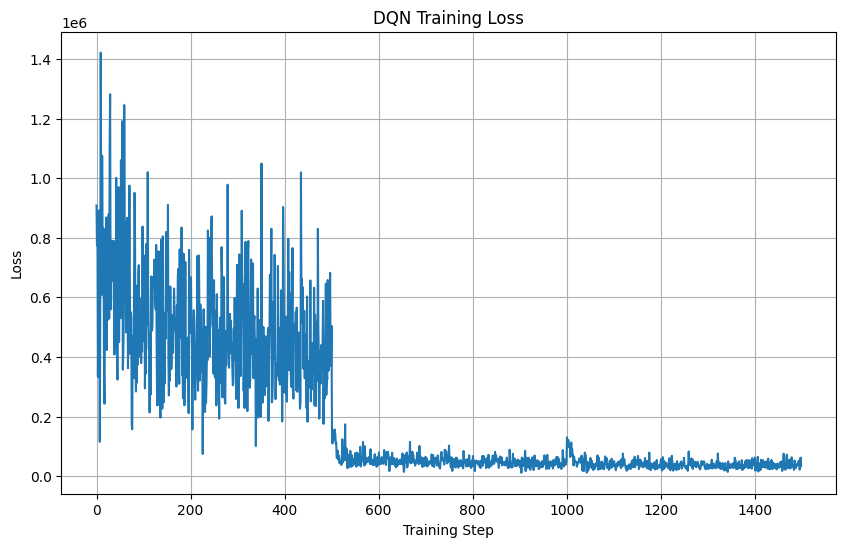

DQN Scheduler implementation ready!
Follow the commented steps above to train on your data.


In [31]:
# 6. Evaluate performance
evaluate_model_performance(trainer, transitions)

# 7. Save model
trainer.save_model('../models/dqn_scheduler_new.pth')

# 8. Plot training history
trainer.plot_training_history()

print("DQN Scheduler implementation ready!")
print("Follow the commented steps above to train on your data.")

We now implemenet the training loop that will take the transition matrix that we built earlier from the state and the actions log to train the model, we will need to perform some extra pre-processing to fit the data into PyTorch eco-system as below

After scaling the transition matrix, we can now proceed to the training loop logic by init the network weights and the optimizer (Adam), we use L1 smooth loss as the criterion.

To train the DQN we take a batch of the state $s_t$, a batch for the reward $r_t$ and a batch for the next state $s_{t+1}$.